## External Sources
+ [Reference](https://medium.com/@josh_2774/deep-learning-with-pytorch-9574e74d17ad)
+ [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data)
+ [PyTorch Learning Rate Decay Documentation](https://pytorch.org/docs/master/optim.html#how-to-adjust-learning-rate)



# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import torch
from torch import nn
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
from time import time
from PIL import Image
import numpy as np
import copy
import seaborn as sns

%matplotlib inline

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Normalize the means and std for all images to match Pre-trained network
### for ImageNet, each color channel was normalized separately
train_transforms = transforms.Compose([transforms.RandomRotation(45),
                                      transforms.RandomResizedCrop(224), #General:224 | Inception: 299
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) 

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) 

# Load the datasets with ImageFolder and apply transforms
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Define the dataloaders for train, validation, and test
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

# class_names = train_data.classes
class_to_idx = train_data.class_to_idx

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [113]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [31]:
# Use GPU if available
if torch.cuda.is_available():
    print('Running on GPU')
    device = torch.device('cuda:0')
else:
    print('Running on CPU')
    device = torch.device('cpu')

# Load pre trained model
# model = models.vgg16(pretrained=True)
# model = models.resnet50(pretrained=True)
# model = models.inception_v3(pretrained=True)
model = models.resnet152(pretrained=True)

model_name = 'resnet152'

model

Running on GPU


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to C:\Users\Desktop/.cache\torch\checkpoints\resnet152-b121ed2d.pth
100%|███████████████████████████████████████████████████████████████████████████████| 230M/230M [02:50<00:00, 1.42MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Transfer Learning of Pre-Trained network to define our Model

In [32]:
# Numebr of Input Features, based on model
model_input_features = {'vgg16': 25088,
                       'resnet50': 2048,
                        'resnet152': 2048,
                       'inception_v3': 2048}

In [33]:
# freeze parameters to not backpropagate through them
for param in model.parameters():
    param.requires_grad = False

# Set Learning Rate
lr=0.001

# New "last step", tailored to our goal and specific to each model
if model_name == 'vgg16':
    model.classifier = nn.Sequential(nn.Linear(model_input_features[model_name], 4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.5), # random drop out 50% of hidden layers
                                 nn.Linear(4096, len(cat_to_name)),
                                 nn.LogSoftmax(dim=1))
    # Only train the classifier parameters
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=lr)
    
elif model_name in ('resnet50', 'resnet152'):
    model.fc = nn.Sequential(nn.Linear(model_input_features[model_name], len(cat_to_name)),
                             nn.LogSoftmax(dim=1))
    # Only train the classifier parameters
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)

elif model_name == 'inception_v3':
    model.fc = nn.Sequential(nn.Linear(model_input_features[model_name], len(cat_to_name)),
                             nn.LogSoftmax(dim=1))
    # Requirements to use Inception_v3
    model.aux_logits = False
    print('ATTENTION: Inception v3 requires the input image to be at least 299 pixel, instead of the usual 224.')
    # Only train the classifier parameters
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
    
criterion = nn.NLLLoss() # Negative Log Likelihood Loss

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### -> Training the Neural Network

In [35]:
epochs = 20
best_model = 0
best_score = 0
training_losses = []
validation_losses = []

# Define Learning Rate Decay using scheduler - as recommended by PyTorch
### Every step_size epochs, lr = lr * gamma
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

start = time()

with open(f'trainingLog2_{model_name}.txt', 'w') as log:
    # using helper function to session awake through long process (over 30 min)
    for epoch in range(epochs):
        # Training Stage
        running_loss = 0
        model.train() #!Important: set train mode, applying dropout etc.
        
        for inputs, labels in train_loader:
            
            # !Important: restart optimizer for every new batch
            optimizer.zero_grad()

            # move input and label tensors to the appropriate device (GPU or CPU)
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Perform forward pass to transform input into output
            outputs = model.forward(inputs) # since last layer is LogSoftMax, output is Log

            # Calculate error. Using Negative Log Loss instead of delta probability
            loss = criterion(outputs, labels)

            # Back propagate
            loss.backward()

            # Calibrate Weights based on Gradient Descent
            optimizer.step()

            # Keep track of training progress
            running_loss += loss.item()
        
        # Keep track of average training loss per epoch
        training_losses.append(running_loss/len(train_loader))
    
        # Validation Stage
        validation_loss = 0
        accuracy = 0
        model.eval() #! Important: enter evaluation mode, no drop-out applied

        with torch.no_grad(): # ! Important: no gradient descent on following calculations
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                predictions = model.forward(inputs)
                batch_loss = criterion(predictions, labels)
                validation_loss += batch_loss.item()

                # Calculate Accuracy
                probabilities = torch.exp(predictions) #proba = exp^(log)
                top_p, top_class = probabilities.topk(1, dim=1) # returns class with higher probability score

                equals = (top_class == labels.view(*top_class.shape)) # True (1) or False (0)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
                # Evaluate model performance and keep only the best
                if accuracy/len(valid_loader) > best_score:
                    best_score = accuracy/len(valid_loader)
                    best_model = copy.deepcopy(model.state_dict())
        
        # Keep track of average validation loss per epoch
        validation_losses.append(validation_loss/len(valid_loader))            
        
        current_lr = optimizer.param_groups[0]['lr']
        
        results_summary = (f'Epoch [{epoch+1}/{epochs}] '
                           f'Learning Rate: {current_lr:.6f} | '
                          f'Train Loss: {running_loss/len(train_loader) :.3f} | '
                          f'Validation Loss: {validation_loss/len(valid_loader) :.3f} | '
                          f'Validation Accuracy: {accuracy/len(valid_loader) :.2%} | '
                          f'Time: {(time()-start):.0f} s\n')
        print(results_summary)

        # saving to log
        log.write(results_summary)
        
        # take a step on scheduler for learning rate decay
        scheduler.step()

# Load best model identified during training/validation process
model.load_state_dict(best_model)
print(f'Best Validation Accuracy: {best_score:.2%}')

Epoch [1/20] Learning Rate: 0.001000 | Train Loss: 2.380 | Validation Loss: 0.813 | Validation Accuracy: 84.47% | Time: 140 s

Epoch [2/20] Learning Rate: 0.001000 | Train Loss: 0.944 | Validation Loss: 0.489 | Validation Accuracy: 88.73% | Time: 279 s

Epoch [3/20] Learning Rate: 0.001000 | Train Loss: 0.672 | Validation Loss: 0.339 | Validation Accuracy: 92.09% | Time: 415 s

Epoch [4/20] Learning Rate: 0.001000 | Train Loss: 0.553 | Validation Loss: 0.308 | Validation Accuracy: 92.45% | Time: 552 s

Epoch [5/20] Learning Rate: 0.001000 | Train Loss: 0.501 | Validation Loss: 0.253 | Validation Accuracy: 94.02% | Time: 687 s

Epoch [6/20] Learning Rate: 0.000100 | Train Loss: 0.384 | Validation Loss: 0.212 | Validation Accuracy: 95.46% | Time: 823 s

Epoch [7/20] Learning Rate: 0.000100 | Train Loss: 0.371 | Validation Loss: 0.207 | Validation Accuracy: 95.58% | Time: 959 s

Epoch [8/20] Learning Rate: 0.000100 | Train Loss: 0.368 | Validation Loss: 0.210 | Validation Accuracy: 94.86%

### Visualizing Model Complexity
To examine model complexity and its under/overfitting pattern, we plot the average accuracy for both Training and Validation dataset along the epochs:

# TODO: fix plot to display model complexity during training

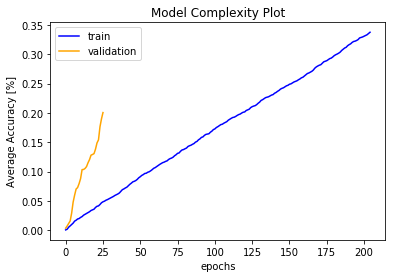

In [45]:
plt.plot(training_losses, c='b', label='train')
plt.plot(validation_losses, c='orange', label='validation')
plt.title('Model Complexity Plot')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [39]:
testing_losses = []
testing_accuracy = []

model.eval() #! Important: enter evaluation mode, no drop-out applied
start = time()

with torch.no_grad(): # ! Important: no gradient descent on following calculations
    for inputs, labels in test_loader: 
        test_loss = 0
        accuracy = 0 
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model.forward(inputs)
        batch_loss = criterion(outputs, labels)
        test_loss += batch_loss.item()

        testing_losses.append(test_loss)

        # Calculate Accuracy
        probabilities = torch.exp(outputs) #proba = exp^(log)
        top_p, top_class = probabilities.topk(1, dim=1) # returns class with higher probability score

        equals = (top_class == labels.view(*top_class.shape)) # True (1) or False (0)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        testing_accuracy.append(accuracy)

        print(f'Test Loss: {test_loss:.3f} | Test Accuracy: {accuracy:.2%} | Time: {(time()-start):.0f} sec')
        
print(f'Overall average Test Accuracy: {sum(testing_accuracy)/len(testing_accuracy):.2%}')

Test Loss: 0.119 | Test Accuracy: 100.00% | Time: 1 sec
Test Loss: 0.318 | Test Accuracy: 87.50% | Time: 1 sec
Test Loss: 0.242 | Test Accuracy: 93.75% | Time: 2 sec
Test Loss: 0.309 | Test Accuracy: 90.62% | Time: 2 sec
Test Loss: 0.244 | Test Accuracy: 93.75% | Time: 3 sec
Test Loss: 0.198 | Test Accuracy: 93.75% | Time: 3 sec
Test Loss: 0.976 | Test Accuracy: 75.00% | Time: 4 sec
Test Loss: 0.276 | Test Accuracy: 93.75% | Time: 5 sec
Test Loss: 0.058 | Test Accuracy: 100.00% | Time: 5 sec
Test Loss: 0.137 | Test Accuracy: 96.88% | Time: 6 sec
Test Loss: 0.465 | Test Accuracy: 84.38% | Time: 6 sec
Test Loss: 0.129 | Test Accuracy: 96.88% | Time: 7 sec
Test Loss: 0.044 | Test Accuracy: 100.00% | Time: 7 sec
Test Loss: 0.036 | Test Accuracy: 100.00% | Time: 8 sec
Test Loss: 0.184 | Test Accuracy: 93.75% | Time: 8 sec
Test Loss: 0.275 | Test Accuracy: 93.75% | Time: 9 sec
Test Loss: 0.096 | Test Accuracy: 100.00% | Time: 10 sec
Test Loss: 0.082 | Test Accuracy: 96.88% | Time: 10 sec
Tes

### Results Log
| Model | Epochs | Optimizer | Dropout | Validation Avg Acc | Test Avg Acc | Epoch Train Time | Checkpoint Size [mb] |
| ---   | ---    | ---       | ---     | ---                | ---           |       ---        | ---                 |
| VGG16 | 20     | Adam      | 0.5     | 90.38%             | 89.37%        |  180 s           | 1,300               |
| ResNet50 | 20  | Adam      |  N/A    | 94.74%             | 93.06%        |  120 s           | 97                  |
| InceptionV13 | 20  | Adam      |  N/A    | 88.22%         | 86.08%        |  157 s           | 103                 |
| ResNet152 | 20  | Adam      |  N/A    | 95.70%             | 93.78%        |  140 s           |         230        |

Interestingly, ResNet50 was the fastest network architecture to train, yielding the best results on the Test Set (93% average accuracy), and having the smaller final model size, with only 97 mb (checkpoint file).

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [40]:
# Once completed, save model as checkpoint
checkpoint = {'epoch': epoch,
              'model_name': model_name,
              'input': model_input_features[model_name],
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'class_to_idx': class_to_idx,
              'class_to_name': cat_to_name}

torch.save(checkpoint, f'checkpoint2_{model_name}.pth')

## -> Loading from checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

> **Tip**: [this solution](https://discuss.pytorch.org/t/problem-loading-model-trained-on-gpu/17745) to allow model trained on GPU to run on CPU device

In [5]:
def load_checkpoint(model_name='vgg16'):
    '''
    This function loads saved parameters and state from previously trained Neural Network.
    Input: file name of checkpoint
    Output: model, optimizer, device (GPU or CPU), loss criterion, and checkpoint dictionary with secondary information
    '''
    # Read from checkpoint.pth saved file
    filename = f'checkpoint2_{model_name}.pth'
    
    # Deserialize 'pickled' file (reading saved checkpoint)
    ### Tip: use map location to enable run on CPU model trained in GPU
    checkpoint = torch.load(filename, map_location=lambda storage, loc: storage)
    
    # Initialize model, applying custom setup for each one
    if model_name == 'vgg16':
        # Load base pre trained model and optimizer
        model = models.vgg16(pretrained=True) 
    
        # New "last step", tailored to our goal
        model.classifier = nn.Sequential(nn.Linear(checkpoint['input'], 4096),
                                         nn.ReLU(),
                                         nn.Dropout(0.5), # random drop out 50% of hidden layers
                                         nn.Linear(4096, len(checkpoint['class_to_idx'])), # output classes: 102
                                         nn.LogSoftmax(dim=1))
    
        optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
        
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Sequential(nn.Linear(checkpoint['input'], len(checkpoint['class_to_idx'])),
                                 nn.LogSoftmax(dim=1))
        
        optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
        
    elif model_name == 'inception_v3':
        model = models.inception_v3(pretrained=True)
        model.fc = nn.Sequential(nn.Linear(checkpoint['input'], len(checkpoint['class_to_idx'])),
                                 nn.LogSoftmax(dim=1))
        model.aux_logits = False
        print('ATTENTION: Inception v3 requires the input image to be at least 299 pixel, instead of the usual 224.')
        
        optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
    
    # load model and optimizer saved state data
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Use GPU if available
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # Apply same custom tranformation on last step (classifier)
    for param in model.parameters():
        param.requires_grad = False
        
    # Bring model to device (CPU or GPU, if available)
    model.to(device)
    # Make sure model is ready to be used for classifying/evaluation
    model.eval()
    
    # Define loss criteria
    criterion = nn.NLLLoss() # Negative Log Likelihood Loss
    
    return model, optimizer, device, criterion, checkpoint

In [6]:
# Call loading function to retrieve model, optimizer, and dictionary with secondary information
model, optimizer, device, criterion, checkpoint = load_checkpoint('resnet50')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\Desktop/.cache\torch\checkpoints\resnet50-19c8e357.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:32<00:00, 3.14MB/s]


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [8]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # resize to 256 pixel
    image = Image.open(image_path).resize((256,256))

    # Center crop to 224 pixel
    width, height = image.size   # Get dimensions
    final_size = 224

    left = (width - final_size)/2
    top = (height - final_size)/2
    right = (width + final_size)/2
    bottom = (height + final_size)/2

    image = image.crop((left, top, right, bottom))

    # Transform image into np.array
    im = np.array(image)

    # Normalize pixels from [0 - 255] to [0 - 1.0] float range
    im = (im - im.min()) / (im.max() - im.min())

    # Normalize as expected by pre-trained model
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    im = (im - mean ) / std
    
    # Transpose moving color channel from third (matplotlib) to first position (pytorch)
    im = im.transpose((2, 0, 1)) # color, x, y
    
    return im

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [9]:
def imshow(image, ax=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
        
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (std * image) + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    # Remove spines/axis
    ax.axis('off')
    
    ax.imshow(image)
    
    return ax

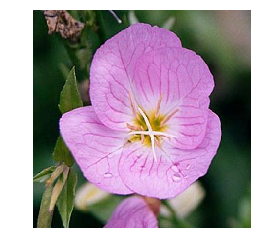

In [10]:
image_path = 'flowers/train/1/image_06734.jpg'

imshow(process_image(image_path));

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

This [StackOverFlow answer](https://stackoverflow.com/questions/49407303/runtimeerror-expected-object-of-type-torch-doubletensor-but-found-type-torch-fl) address the conversion error between Float or Double.
> It is recommended to convert the inputs to `float` rather than converting the model to `double`, due to performance of mathematical computation on GPU

In [11]:
def predict(image_path, model, k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    processed_image = process_image(image_path)

    # Fix: cast input image as float
    input_tensor = torch.tensor(processed_image).float()
        
    # Use GPU if available
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    input_tensor = input_tensor.to(device)
    model.to(device)
    
    # As recommended, convert input image to FloatTensor
    input_tensor = input_tensor.float()
    
    # Add expected batch information for a single image
    input_tensor = input_tensor.unsqueeze_(0)

    output = model.forward(input_tensor)

    probabilities = torch.exp(output)
    top_p, top_class = probabilities.topk(k, dim=1)

    # unpack from Tensor back to simple list
    top_class = top_class.squeeze().tolist()
    top_p = top_p.squeeze().tolist()
        
    # Convert indices to actual classes
    idx_to_class = {val: key for key,val in class_to_idx.items()}
    
    top_label = [idx_to_class[class_] for class_ in top_class]
    top_flower = [cat_to_name[label] for label in top_label]
        
    return top_p, top_label, top_flower

In [12]:
probs, classes, flowers = predict(image_path, model)

print(probs)
print(classes)
print(flowers)

[0.24928326904773712, 0.15385030210018158, 0.09774000942707062, 0.09673572331666946, 0.07565198093652725]
['52', '1', '69', '19', '51']
['wild pansy', 'pink primrose', 'windflower', 'balloon flower', 'petunia']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [13]:
# Display an image along with the top 5 classes
import seaborn as sns
def display_result(image_path, model):
    
    fig, axes = plt.subplots(2,1, figsize=(5,8))
    
    # Set up title
    flower_num = image_path.split('/')[2]
    title = checkpoint['class_to_idx'].get(str(flower_num))
        
    # Plot flower
    img = process_image(image_path)
    axes[0].set_title(title)
    imshow(img, ax=axes[0]);
    
    # Make prediction
    probs, classes, flowers = predict(image_path, model)
    
    # Plot bar chart
    sns.barplot(x=probs, y=flowers, ax=axes[1],color=sns.color_palette()[0])
    plt.show();

In [25]:
!dir flowers\test\7

 Volume in drive C has no label.
 Volume Serial Number is E272-4EF5

 Directory of C:\Users\Desktop\Dropbox\Data Science\Udacity\Intro to ML\Project2_DeepLearning\TransferLearning\2_FlowerClassifier\flowers\test\7

09/10/2019  08:44 PM    <DIR>          .
09/10/2019  08:44 PM    <DIR>          ..
02/19/2009  04:21 PM            48,191 image_07211.jpg
02/19/2009  04:21 PM            26,608 image_07215.jpg
02/19/2009  04:21 PM            52,964 image_07218.jpg
02/19/2009  04:21 PM            41,389 image_07219.jpg
02/19/2009  04:21 PM            34,564 image_08099.jpg
02/19/2009  04:21 PM            25,894 image_08104.jpg
               6 File(s)        229,610 bytes
               2 Dir(s)  222,170,292,224 bytes free


In [20]:
try:
    !ls flowers/test/11
except:
    !dir flowers\test\11

'ls' is not recognized as an internal or external command,
operable program or batch file.


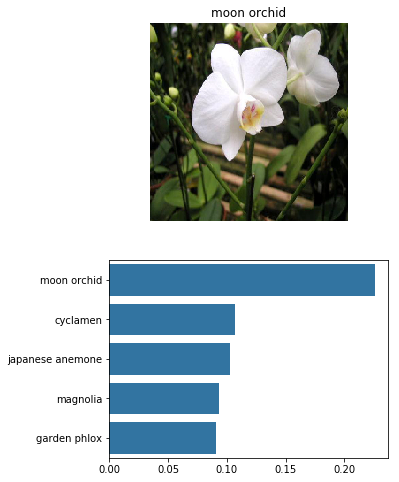

In [30]:
image_path = 'flowers/test/7/image_07219.jpg'
display_result(image_path, model)